# Implementation of Value at Risk and Conditional Value at Risk metrics using:
    1. Historical Data Method
    2. Parametric Method (Variance-Covariance)
    3. Monte Carlo Method

In [42]:
# Install dependencies
%pip install --upgrade yfinance
%pip install --upgrade scipy


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [43]:
# import dependencies
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import matplotlib.pyplot as plt

### We will first define some functions to help us fetch and process stock data from Yahoo Finance:

In [60]:
# import data from Yahoo
def get_stock_data_yfinance(stocks, start, end):
    stock_data = yf.download(stocks, start=start, end=end, group_by='ticker')
    close_prices = pd.DataFrame()
    for stock in stocks:
        close_prices[stock] = stock_data[stock, 'Close']
    return close_prices

# get the full returns, mean returns, and covariance matrix from the imported data
def get_data(stocks, start_time, end_time):
    # load the data from Yahoo
    stockData = get_stock_data_yfinance(stocks, start_time, end_time)
    # find the daily precentage change in the value of the stock 
    returns = stockData.pct_change()
    # calculate the meansReturns dataframe based on the average daily percentage change in the value of the stock
    meanReturns = returns.mean()
    # calculate the covariance matrix
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

# calculate portfolio performance (returns + standard deviation)
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)) ) * np.sqrt(Time)
    return returns, std

### Initialise the data for analysis

In [61]:
stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN']  # chosen set of stocks (must provide the ticker symbol for each stock)
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=800) # modelling based on historic data spanning 800 days

returns, meanReturns, covMatrix = get_data(stocks, start_time=startDate, end_time=endDate)
returns = returns.dropna()

np.random.seed(42)
weights = np.random.random(len(stocks)) # initialising random weights / capital allocation for the chosen stocks in the portfolio
weights /= np.sum(weights) # normalising the weights so that the sum of all weights equates to 1

returns['portfolio'] = returns.dot(weights) # calculating porfolio returns based on the chosen weights/allocation and the returns from each stock in the portfolio

initial_investment = 10000 # initialising the initial investment / capital sum to be allocated
investment_days = 100 # 100 days

[*********************100%%**********************]  4 of 4 completed


### Historical Data

Here we make no assumptions about the distribution of the data

In [62]:
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

hVaR = -historicalVaR(returns['portfolio'], alpha=5)*np.sqrt(investment_days)
hCVaR = -historicalCVaR(returns['portfolio'], alpha=5)*np.sqrt(investment_days)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, investment_days)

print('Expected Portfolio Return:      ' + str(round(initial_investment*pRet,2)) + '\n')
print('Value at Risk 95th Confidence Level    :      ' +  str(round(initial_investment*hVaR,2)))
print(f"This means that the maximum expected loss in the worst 5% of cases is {round(initial_investment * hVaR, 2)}, or in other words, there's a 95% confidence that the portfolio will not lose more than {round(initial_investment * hVaR, 2)} of value in the next {investment_days} days\n")
print('Conditional VaR 95th Confidence Level  :      ' + str(round(initial_investment*hCVaR,2)))
print(f"This means that average loss given that the loss is beyond the VaR threshold is {round(initial_investment*hCVaR,2)}")


Expected Portfolio Return:      1098.07

Value at Risk 95th Confidence Level    :      2575.2
This means that the maximum expected loss in the worst 5% of cases is 2575.2, or in other words, there's a 95% confidence that the portfolio will not lose more than 2575.2 of value in the next 100 days

Conditional VaR 95th Confidence Level  :      3583.84
This means that average loss given that the loss is beyond the VaR threshold is 3583.84


### Parametric Method (Variance-Covariance)
Here we make an assumption on the distribution of returns and use the historical portfolio returns and standard deviations (estimates) to define parameters for the model. 

We have implemented two parametric VaR models:

    - normal distribution

    - t-distribution (heavier tails)

In [63]:
def var_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    """
    Please Note:

    -> When the degrees of freedom (dof) are large, the t-distribution approximates the normal distribution

    -> The lower the degrees of freedom (dof), the heavier the tails of the distribution
    """
    # because the distribution is symmetric
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

def cvar_parametric(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    """
    Please Note:

    -> When the degrees of freedom (dof) are large, the t-distribution approximates the normal distribution

    -> The lower the degrees of freedom (dof), the heavier the tails of the distribution
    """
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

normVaR = var_parametric(pRet, pStd)
normCVaR = cvar_parametric(pRet, pStd)

tVaR = var_parametric(pRet, pStd, distribution='t-distribution')
tCVaR = cvar_parametric(pRet, pStd, distribution='t-distribution')

print("Normal VaR 95th Confidence Level       :      ", round(initial_investment*normVaR,2))
print("Normal CVaR 95th Confidence Level       :      ", round(initial_investment*normCVaR,2))
print("t-dist VaR 95th Confidence Level        :      ", round(initial_investment*tVaR,2))
print("t-dist CVaR 95th Confidence Level       :      ", round(initial_investment*tCVaR,2))
     

Normal VaR 95th Confidence Level       :       1682.33
Normal CVaR 95th Confidence Level       :       2388.67
t-dist VaR 95th Confidence Level        :       1583.87
t-dist CVaR 95th Confidence Level       :       2546.64


### Monte Carlo Simulation

We use a Monte Carlo simulation of a stock portfolio and then use the functions for historical VaR and CVaR to calculate our risk parameters The main advantage here is we could define individual models/stock dynamics for individual assets.

Value at Risk at the 95th Confidence Level: 1792.40
Conditional Value at Risk at the 95th Confidence Level: 2364.20


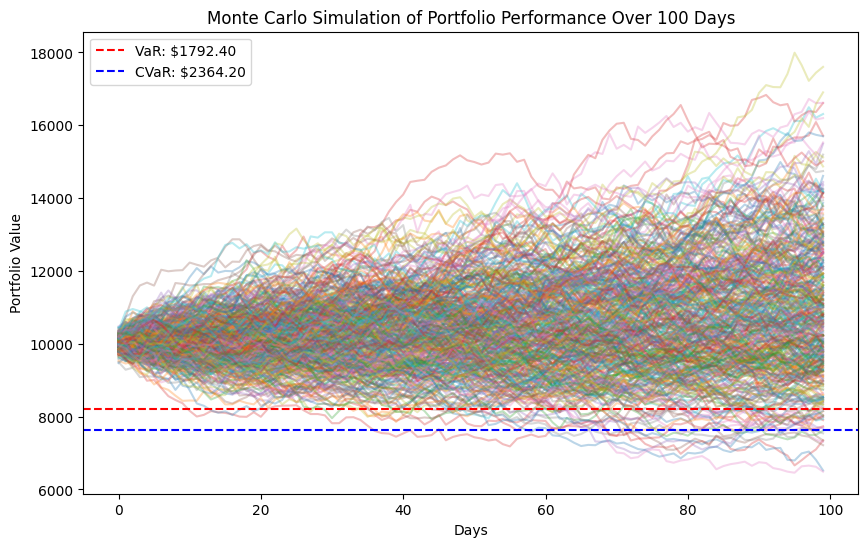

In [69]:
# Monte Carlo simulation function
def run_monte_carlo_simulations(weights, num_simulations, investment_days, covMatrix, initial_investment, mean_matrix):
    """
    Args:
        weights: The allocation of capital among the stocks
        num_simulations: Number of simulated paths the function will generate
        investment_days: Number of days over which the portfolio will be simulated
        mean_matrix: A matrix of size investment_days by number of stocks created from the values of the mean_returns dataframe
        cov_matrix : The covariance matrix from the stock data

    Returns:
        portfolio_values: Cumulative value of the porfolio after the simulation
    """
    portfolio_values = np.zeros((investment_days, num_simulations))
    for i in range(num_simulations):
        # we are assuming that daily returns are distributed buy a multivariate normal distribution
        Z = np.random.normal(size=(investment_days, len(weights))) # samples from the normal distribution
        L = np.linalg.cholesky(covMatrix) # Cholesky Decomposition is used to determine the lower triangular matrix
        daily_returns = mean_matrix.T + np.inner(L, Z)
        portfolio_values[:, i] = np.cumprod(np.inner(weights, daily_returns.T)+1)*initial_investment
    return portfolio_values

# Run the Monte Carlo simulation
def run_monte_carlo_model(num_simulations, investment_days, initial_investment, meanReturns, covMatrix):
    """
    Args:
        num_simulations: Number of simulated paths the function will generate
        investment_days: Number of days over which the portfolio will be simulated
        stocks:  List of stock names given as stock symbols
        start_time : Start time in the following format YYYY-MM-DD 
        end_time : End time in the following format YYYY-MM-DD
    
    Returns:
        simulation results
    """
    mean_matrix = np.full(shape=(investment_days, len(weights)), fill_value=meanReturns)
    portfolio_sims = run_monte_carlo_simulations(weights, num_simulations, investment_days, covMatrix, initial_investment, mean_matrix)
    
    return portfolio_sims

# Calculate the the Value at Risk
def monteCarloVar(returns, threshold = 5):
    """
    Args:
        returns: a pandas series of returns
        threshold: the chance that an loss will occur
    
    Returns:
        percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, threshold)
    else:
        raise TypeError("Input must be a pandas Series object")

# Calculate the the Conditional Value at Risk / Expected Shortfall
def monteCarloCVar(returns, threshold = 5):
    """
    Args:
        returns: a pandas series of returns
        threshold: the chance that an loss will occur
    
    Returns:
        Excepted Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVar = returns <= monteCarloVar(returns, threshold=threshold)
        return returns[belowVar].mean()
    else:
        raise TypeError("Input must be a pandas Series object")


num_simulations = 400 # number of MC simulations to be modelled
portfolio_sims = run_monte_carlo_model(num_simulations, investment_days, initial_investment, meanReturns, covMatrix)
portfolio_results = pd.Series(portfolio_sims[-1, :]) # we only consider the porfolio outcome on the last day
mcVar = initial_investment - monteCarloVar(portfolio_results)
mcCVar = initial_investment - monteCarloCVar(portfolio_results)

print(f"Value at Risk at the 95th Confidence Level: {mcVar:.2f}")
print(f"Conditional Value at Risk at the 95th Confidence Level: {mcCVar:.2f}")

    # Plot results
plt.figure(figsize=(10, 6))
plt.plot(portfolio_sims, alpha=0.3)
plt.axhline(y=initial_investment - mcVar, color='r', linestyle='--', label=f'VaR: ${mcVar:.2f}')
plt.axhline(y=initial_investment - mcCVar, color='b', linestyle='--', label=f'CVaR: ${mcCVar:.2f}')
plt.title(f'Monte Carlo Simulation of Portfolio Performance Over {investment_days} Days')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()



### Comparison of each VaR & CVaR method

In [73]:
print("\nVaR:")

print(' Historical VaR at the 95th Confidence Level   :      ', round(investment_days*hVaR,2))
print(" Normal VaR at the 95th Confidence Level       :      ", round(investment_days*normVaR,2))
print(" t-dist VaR at the 95th Confidence Level       :      ", round(investment_days*tVaR,2))
print(" MC VaR  at the 95th Confidence Level          :      ", round(mcVar,2))


print("\nCVaR:")

print(' Historical CVaR at the 95th Confidence Level  :      ', round(investment_days*hCVaR,2))
print(" Normal CVaR at the 95th Confidence Level      :      ", round(investment_days*normCVaR,2))
print(" t-dist CVaR at the 95th Confidence Level      :      ", round(investment_days*tCVaR,2))
print(" MC CVaR at the 95th Confidence Level          :      ", round(mcCVar,2))


VaR:
 Historical VaR at the 95th Confidence Level   :       25.75
 Normal VaR at the 95th Confidence Level       :       16.82
 t-dist VaR at the 95th Confidence Level       :       15.84
 MC VaR  at the 95th Confidence Level          :       1792.4

CVaR:
 Historical CVaR at the 95th Confidence Level  :       35.84
 Normal CVaR at the 95th Confidence Level      :       23.89
 t-dist CVaR at the 95th Confidence Level      :       25.47
 MC CVaR at the 95th Confidence Level          :       2364.2
